In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.utils import shuffle
pip show scikit-learn

In [ ]:
def load_geo_data(geoID, disease, project_dir):
    # file path
    express_file = f"{project_dir}{disease}_{geoID}/{geoID}_norm_exprSet.csv"
    
    # read expression data
    express_data = pd.read_csv(express_file, index_col=0).T
    
    # meta file
    meta_file = f"{project_dir}{disease}_{geoID}/{geoID}_meta_info.csv"
    
    # read the meta info
    meta_data = pd.read_csv(meta_file, index_col=0)

    # combine expression and meta data
    combined_data = express_data.join(meta_data)
    
    return express_data, meta_data, combined_data


def standardize_gene_expression(combined_data):
    gene_expression_data = combined_data.iloc[:, :-1]
    labels = combined_data.iloc[:, -1]

    # normalization
    scaler = StandardScaler()
    standardized_gene_expression_data = pd.DataFrame(scaler.fit_transform(gene_expression_data), 
                                                     index   = gene_expression_data.index,
                                                     columns = gene_expression_data.columns)
    
    standardized_combined_data = pd.concat([standardized_gene_expression_data, labels], axis=1)
    
    return standardized_combined_data


def train_model(X_train, y_train, model_type="svm"):
    if model_type == "svm":
        model = SVC(probability=True)
    elif model_type == "random_forest":
        model = RandomForestClassifier(random_state=42)
    elif model_type == "elastic_net":
        model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42)
    else:
        raise ValueError("Unsupported model type. Choose from 'svm', 'random_forest', 'elastic_net'")
    
    model.fit(X_train, y_train)
    return model


def plot_roc_curve(models, X_test, y_test, X_independent, y_independent):
    plt.figure()

    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        y_prob_ind = model.predict_proba(X_independent)[:, 1]
        fpr_ind, tpr_ind, _ = roc_curve(y_independent, y_prob_ind)
        roc_auc_ind = auc(fpr_ind, tpr_ind)

        plt.plot(fpr, tpr, lw=2, label=f'{model_name} Train (area = {roc_auc:.2f})')
        plt.plot(fpr_ind, tpr_ind, lw=2, linestyle='--', label=f'{model_name} Test (area = {roc_auc_ind:.2f})')

    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_roc_curve_single_dataset(ax, models, X_new, y_new, dataset_name):
    # Compute ROC curves and AUC scores
    for model_name, model in models.items():
        y_new_pred_prob = model.predict_proba(X_new)[:, 1]
        fpr, tpr, _ = roc_curve(y_new, y_new_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{dataset_name}')
    ax.legend(loc="lower right")

def filter_data_by_group(combined_data, data, meta_data, group_col='group', filter_value=-1):
    # filtering combined_data
    filtered_combined_data = combined_data[combined_data[group_col] != filter_value]
    filtered_indices = filtered_combined_data.index
    filtered_data = data.loc[filtered_indices]
    filtered_meta_data = meta_data.loc[filtered_indices]
    group_unique_filtered = filtered_combined_data[group_col].unique()
    num_classes_filtered = len(group_unique_filtered)
    return filtered_combined_data, filtered_data, filtered_meta_data

## 1. Loading and processing datasets

In [ ]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

### 1.1 Loading datasets

In [ ]:
project_dir = "/Path/to/osteoporosis_sarcopenia_analysis/output_degs/"

# Osteroporosis
GSE35959_express_data, GSE35959_meta_data, GSE35959_combined_data    =  load_geo_data("GSE35959",  "Osteoporosis", project_dir)
GSE56815_express_data, GSE56815_meta_data, GSE56815_combined_data    =  load_geo_data("GSE56815",  "Osteoporosis", project_dir)
GSE56814_express_data, GSE56814_meta_data, GSE56814_combined_data    =  load_geo_data("GSE56814",  "Osteoporosis", project_dir)
GSE7158_express_data,  GSE7158_meta_data,  GSE7158_combined_data     =  load_geo_data("GSE7158",   "Osteoporosis", project_dir)
GSE62402_express_data, GSE62402_meta_data, GSE62402_combined_data    =  load_geo_data("GSE62402",  "Osteoporosis", project_dir)
GSE13850_express_data, GSE13850_meta_data, GSE13850_combined_data    =  load_geo_data("GSE13850",  "Osteoporosis", project_dir)
GSE7429_express_data,  GSE7429_meta_data,  GSE7429_combined_data     =  load_geo_data("GSE7429",   "Osteoporosis", project_dir)
GSE80614_express_data, GSE80614_meta_data, GSE80614_combined_data    =  load_geo_data("GSE80614",  "Osteoporosis", project_dir)

# Sarcopenia
GSE1428_express_data, GSE1428_meta_data, GSE1428_combined_data       =  load_geo_data("GSE1428",   "Sarcopenia",   project_dir)
GSE136344_express_data, GSE136344_meta_data, GSE136344_combined_data =  load_geo_data("GSE136344", "Sarcopenia",   project_dir)
GSE362_express_data, GSE362_meta_data, GSE362_combined_data          =  load_geo_data("GSE362",    "Sarcopenia",   project_dir)

In [ ]:
## Filtering data
GSE136344_combined_data, GSE136344_express_data, GSE136344_meta_data = filter_data_by_group(combined_data = GSE136344_combined_data,
                                                                                             data          = GSE136344_express_data,
                                                                                             meta_data     = GSE136344_meta_data,
                                                                                             group_col     = 'group',
                                                                                             filter_value  = -1)

### 1.2 Standardization

In [ ]:
GSE35959_std_combined_data  = standardize_gene_expression(GSE35959_combined_data)
GSE56815_std_combined_data  = standardize_gene_expression(GSE56815_combined_data)
GSE56814_std_combined_data  = standardize_gene_expression(GSE56814_combined_data)
GSE7158_std_combined_data   = standardize_gene_expression(GSE7158_combined_data)
GSE62402_std_combined_data  = standardize_gene_expression(GSE62402_combined_data)
GSE13850_std_combined_data  = standardize_gene_expression(GSE13850_combined_data)
GSE7429_std_combined_data   = standardize_gene_expression(GSE7429_combined_data)
GSE80614_std_combined_data  = standardize_gene_expression(GSE80614_combined_data)

GSE1428_std_combined_data   = standardize_gene_expression(GSE1428_combined_data)
GSE136344_std_combined_data = standardize_gene_expression(GSE136344_combined_data)
GSE362_std_combined_data    = standardize_gene_expression(GSE362_combined_data)

We will select hub genes as the features.

### 1.3 Combining multiple datasets for training in the next step

In [ ]:
combined_std_data = pd.concat([GSE35959_std_combined_data, 
                               GSE62402_std_combined_data, GSE13850_std_combined_data, 
                               GSE56815_std_combined_data, GSE56814_std_combined_data, 
                               GSE136344_std_combined_data, GSE1428_std_combined_data])

# shuffle the data
combined_std_data = shuffle(combined_std_data, random_state=42)

# select feature genes and the corresponding labels
X = combined_std_data[hub_genes]
y = combined_std_data['group']

# normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5-fold cross validation
cv = StratifiedKFold(n_splits=5)

# Machine learning models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(C=1.0, random_state=42)
}

In [ ]:
# check if there are NaN rows
nan_rows = combined_std_data[hub_genes][combined_std_data[hub_genes].isnull().any(axis=1)]
print(nan_rows)

## 2. Machine learning model training and validation in the indepedent datasets

In [ ]:
hub_genes = ["BCL6", "DDIT4", "FLNA", "FOXO1", "IRS1", "NFKBIA", "PGK1", "STAT3"] #"FOXO3",

In [ ]:
for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc')
    print(f'{model_name} AUC: {np.mean(scores):.2f} ± {np.std(scores):.2f}')

def plot_roc_curve_single_dataset(models, X_new, y_new, title, ax):
    for model_name, model in models.items():
        model.fit(X_scaled, y)
        y_new_pred_prob = model.predict_proba(X_new)[:, 1]
        fpr, tpr, _     = roc_curve(y_new, y_new_pred_prob)
        roc_auc         = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
        
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curves for {title}')
    ax.legend(loc="lower right")

In [ ]:
output_path = os.path.join(os.getcwd(), "output_degs", "ROC_curve")
if not os.path.exists(output_path):
    os.makedirs(output_path)

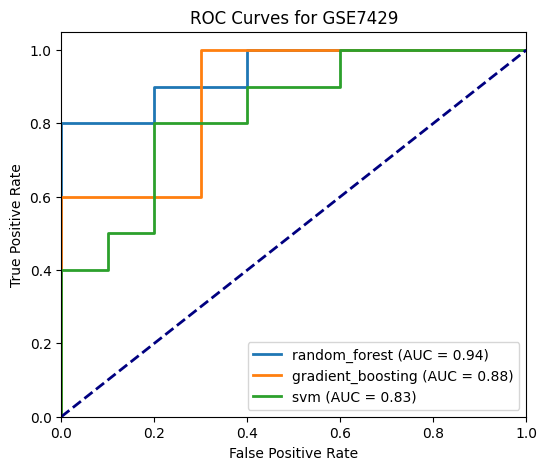

In [25]:
fig, ax = plt.subplots(figsize=(6, 5))
X_new = scaler.transform(GSE7429_std_combined_data[hub_genes])
y_new = GSE7429_std_combined_data['group']
plot_roc_curve_single_dataset(models, X_new, y_new, "GSE7429", ax)
plt.savefig(os.path.join(output_path, 'roc_curve_GSE7429.pdf'), format='pdf')
plt.show()

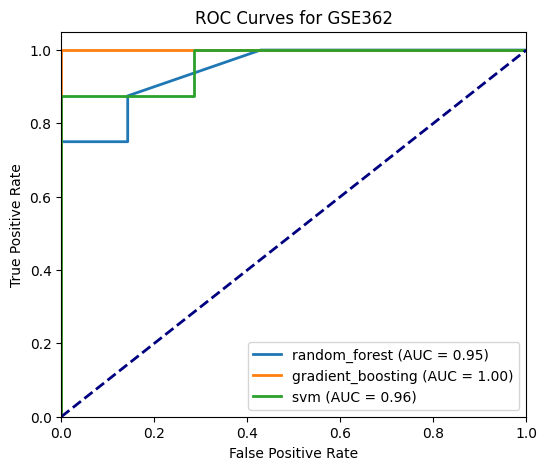

In [26]:
fig, ax = plt.subplots(figsize=(6, 5))
X_new = scaler.transform(GSE362_std_combined_data[hub_genes])
y_new = GSE362_std_combined_data['group']
plot_roc_curve_single_dataset(models, X_new, y_new, "GSE362", ax)
plt.savefig(os.path.join(output_path, 'roc_curve_GSE362.pdf'), format='pdf')
plt.show()

## 3. SHAP analysis

In [ ]:
X_scaled.shape
models

In [ ]:
# RandomForest feature importance
rf_importance = models["Random Forest"].feature_importances_

# Create the SHAP Explainer
explainer = shap.TreeExplainer(models["Random Forest"])
shap_values = explainer.shap_values(X_scaled)

shap_values_class_1 = shap_values[:, :, 1]
shap_values_class_0 = shap_values[:, :, 0]

# SHAP summary plot
shap.summary_plot(shap_values_class_1, X_scaled, show=False)

output_dir = './output_degs/shap'
output_file = os.path.join(output_dir, 'shap_summary_plot_rf.pdf')
os.makedirs(output_dir, exist_ok=True)
plt.savefig(output_file, bbox_inches='tight')